## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from neuralprophet import NeuralProphet
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

c:\Miniconda3\envs\intern\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


## Load Data

In [2]:
df_week_2020_23 = pd.read_csv('./data/VolumeDataset_2020_to_2023.csv')
df_daily_2021_23 = pd.read_csv('./data/data_dailly_2021_to_2023.csv')
df_monthly_2020_23 = pd.read_csv('./data/Month_clean_data.csv')
df_jan24_march24 = pd.read_excel('./data/data_jan24_March24.xlsx')


## Clean data

In [12]:
# data = []
# temp_dp = []
# c1 = 0
# c2 = 0
# bulk = 1
# for i in range(1, df_week_2020_23.shape[0]+1):

#     temp_dp.append(df_week_2020_23.iloc[i-1].values[2:])
    
#     c1+=1
#     temp = [bulk]
#     if c2 == 2 and c1 == 5:
#         dp = [sum(x) for x in zip(*temp_dp)]
#         temp.extend(dp)
#         temp_dp.clear()
#         data.append(temp)
#         bulk+=1
#         c1 = 0
#         c2 = 0
        
#     elif c2 != 2 and c1 == 4:
#         dp = [sum(x) for x in zip(*temp_dp)]
#         temp_dp.clear()
#         temp.extend(dp)
#         data.append(temp)
#         bulk+=1
#         c1 = 0
#         c2+=1
# new_col = ['Month']
# new_col.extend(df_week_2020_23.columns[2:])
# df_month = pd.DataFrame(data, columns=new_col)
# df_daily_2021_23['Date'] = pd.to_datetime(df_daily_2021_23['Date'],format='%d-%m-%Y')
# for col in  df_daily_2021_23.columns[1:]:
#     df_daily_2021_23[col] = pd.to_numeric(df_daily_2021_23[col], errors='coerce')
# date = []
# year = 2020
# for month in df_month.iterrows():
#     m = int((month[1][0]-1)%12)+1    
#     date.append(f'1-{m}-{year}')
#     if m== 12:
#         year+=1
# date
# df_month['Date'] = date
# col = df_month.pop('Date')
# df_month.insert(0, 'Date', col)

### Normalised data (To find which is high and low varience regions)

In [3]:
nd = df_monthly_2020_23[['Date', 'Month']]
for region in df_monthly_2020_23.columns[2:-2]:
    mini = df_monthly_2020_23[region].min()
    maxi = df_monthly_2020_23[region].max()
    nd[region] = (df_monthly_2020_23[region]-mini)/(maxi-mini)

<Axes: >

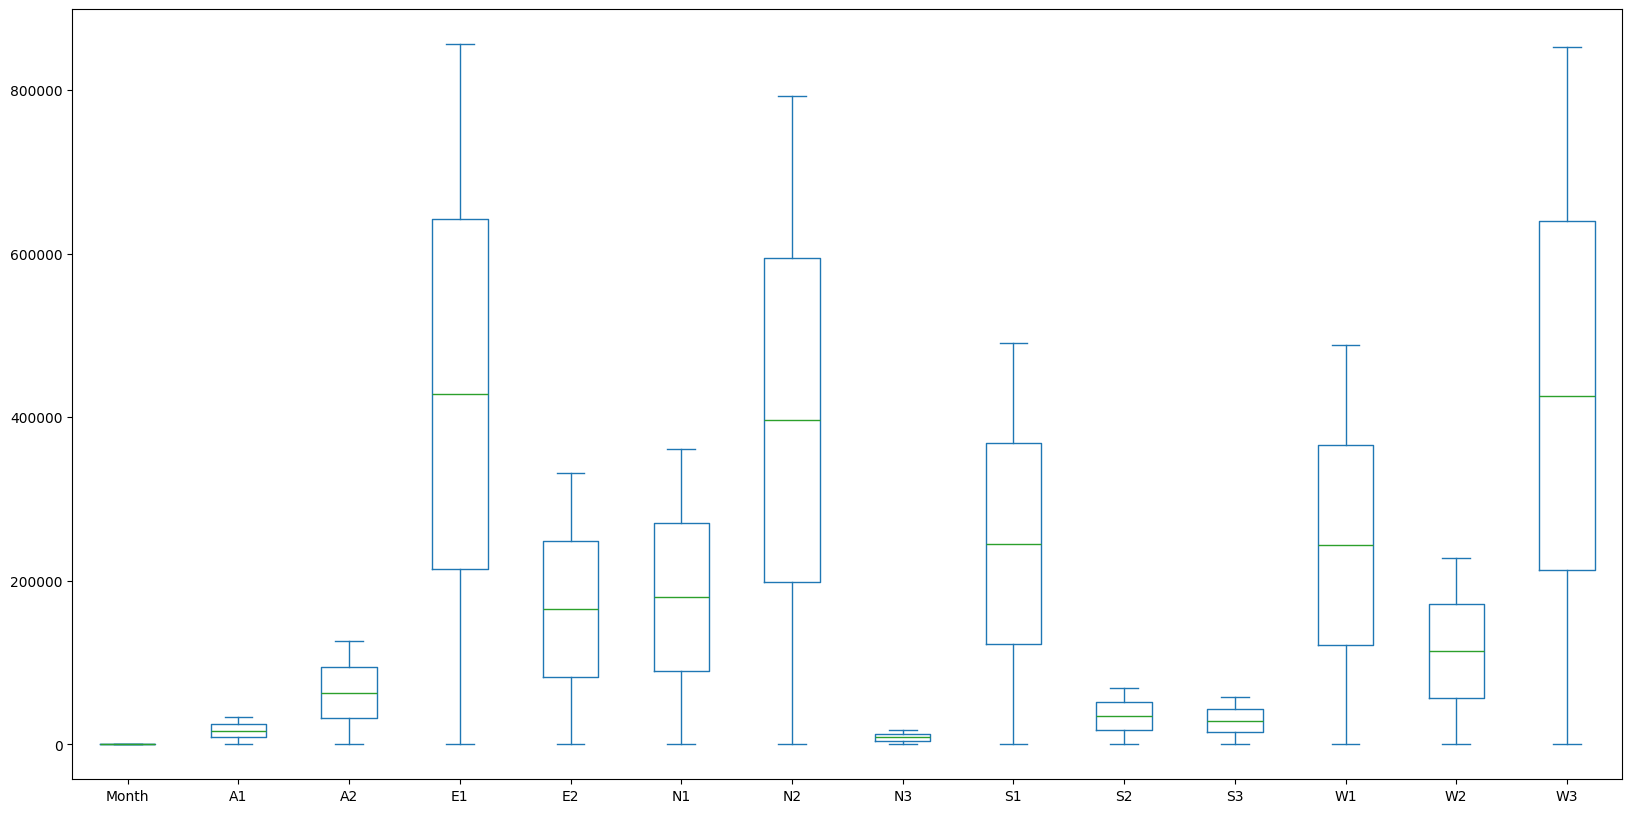

In [4]:
pd.concat([nd.iloc[:, 1:].std().rename("SD"), df_monthly_2020_23.iloc[:, 1:-2].mean().rename("Mean")],axis=1).T.plot.box(figsize=(20, 10))

<BarContainer object of 13 artists>

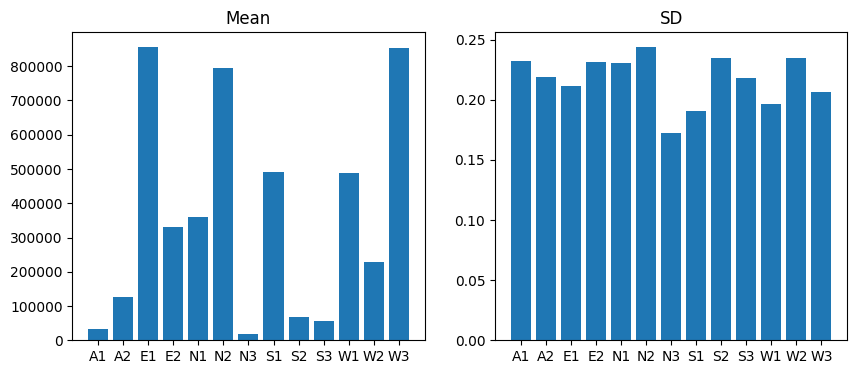

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].bar(df_monthly_2020_23.columns[2:-2],df_monthly_2020_23.iloc[:, 2:-2].mean())
axes[0].set_title('Mean')
axes[1].set_title('SD')
axes[1].bar(df_monthly_2020_23.columns[2:-2],nd.iloc[:, 2:].std().rename("SD"))

In [21]:
print(f'High Mean : {df_monthly_2020_23.iloc[:, 2:-2].mean().sort_values(ascending=False)[:3].index.values}')
print(f'Low Mean : {df_monthly_2020_23.iloc[:, 2:-2].mean().sort_values(ascending=False)[:].index.values}\n')
print(f'High SD : {nd.iloc[:, 2:].std().sort_values(ascending=False)[:].index.values}')
print(f'Low SD : {nd.iloc[:, 2:].std().sort_values(ascending=False)[-3:].index.values}')

print("HM/HV - N2, HM/LV - W3, LM/HV - S2")

# print(f"Null Values in each : \n 1. N2 : {}")


High Mean : ['E1' 'W3' 'N2']
Low Mean : ['E1' 'W3' 'N2' 'S1' 'W1' 'N1' 'E2' 'W2' 'A2' 'S2' 'S3' 'A1' 'N3']

High SD : ['N2' 'W2' 'S2' 'A1' 'E2' 'N1' 'A2' 'S3' 'E1' 'W3' 'W1' 'S1' 'N3']
Low SD : ['W1' 'S1' 'N3']
HM/HV - N2, 


## Prediction
### High varience - Low demand

In [36]:
s1_data = df_monthly_2020_23.loc[:,['Date', 'S1']]
s1_data.columns = ['ds', 'y']
s1_data.fillna(0.00,inplace=True)

In [34]:
df_monthly_2020_23['Date'] = pd.to_datetime(df_monthly_2020_23['Date'],format='%d-%m-%Y')

In [37]:
s1 = NeuralProphet(yearly_seasonality=True, weekly_seasonality=False, n_changepoints=10)
s1.fit(s1_data, freq="M", epochs=1000)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [97.917]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


Epoch 208:  21%|██        | 208/1000 [00:07<00:26, 29.66it/s, loss=0.0597, v_num=18, MAE=1.88e+5, RMSE=2.54e+5, Loss=0.0584, RegLoss=0.000]

INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (6) is too small than the required number                     for the learning rate finder (204). The results might not be optimal.


Finding best initial lr: 100%|██████████| 204/204 [00:00<00:00, 218.86it/s]


Epoch 1000: 100%|██████████| 1000/1000 [00:00<00:00, 20173.36it/s, loss=0.0325, v_num=19, MAE=1.21e+5, RMSE=1.74e+5, Loss=0.0307, RegLoss=0.000]


,MAE,RMSE,Loss,RegLoss,epoch
0,790488.812500,1.013426e+06,0.443517,0.0,0
1,761746.187500,9.967130e+05,0.423431,0.0,1
2,735229.500000,9.516181e+05,0.404286,0.0,2
3,706620.437500,8.861793e+05,0.384393,0.0,3
4,682724.812500,8.609470e+05,0.367778,0.0,4
...,...,...,...,...,...
995,121049.117188,1.725954e+05,0.030691,0.0,995
996,121088.562500,1.657948e+05,0.030709,0.0,996
997,121074.125000,1.718056e+05,0.030694,0.0,997
998,121069.312500,1.685537e+05,0.030694,0.0,998


In [38]:
future = s1.make_future_dataframe(s1_data, periods=3, n_historic_predictions=True)
forecast = s1.predict(future)
forecast['y']=pd.concat([df_monthly_2020_23['E1']], axis=0, ignore_index=True)


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [97.917]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [98.039]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [98.039]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.data.processing._handle_missing_data) - Dropped 3 rows at the end with NaNs in 'y' column.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 236.67it/s]


INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [39]:
s1.plot(forecast)

ERROR - (NP.plotly.plot) - plotly-resampler is not installed. Please install it to use the resampler.
